In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Recommender systems/RecSys_PyTorch-master

/content/drive/MyDrive/Recommender systems/RecSys_PyTorch-master


In [ ]:
pip install omegaconf

In [ ]:
# Import packages
import os
import io
import torch
import csv
#import models
import time
from time import strftime, sleep
import datetime
from dataclasses import dataclass, field
import abc
from argparse import Namespace
import pandas as pd
import numpy as np
import scipy.sparse as sp
from typing import List, Dict, Iterable, MutableMapping, Union, Optional, Tuple
from pathlib import Path
from typing import List, Tuple
from dataclasses import dataclass, field
import random
import math
import logging
from collections import OrderedDict
from utils.stats import Statistics
import torch.nn as nn
import torch.nn.functional as F


from omegaconf import OmegaConf

#PREPROCESS

In [ ]:
def split_into_tr_val_te(data:pd.DataFrame, generalization:str, num_valid_items:Union[int, float], num_test_items:Union[int, float], 
                        holdout_users:int, split_random:bool, user2id:Dict, item2id:Dict) -> Dict:
    prepro_data_dict = {}
    if generalization == 'weak':
        # Split data into train, valid, test
        train_data, test_data = split_input_target_by_users(data, test_ratio=num_valid_items, split_random=split_random)
        train_data, valid_data = split_input_target_by_users(train_data, test_ratio=num_test_items, split_random=split_random)

        prepro_data_dict['train'] = train_data
        prepro_data_dict['valid'] = valid_data
        prepro_data_dict['test'] = test_data
    else:
        user_ids = np.array(list(user2id.values()))
        num_users = len(user_ids)
        num_valid_users = num_test_users = int(num_users * holdout_users)
        num_train_users = num_users - num_valid_users - num_test_users

        perm = np.random.permutation(num_users)
        
        train_user_idx = perm[:num_train_users]
        valid_user_idx = perm[num_train_users: num_train_users + num_valid_users]
        test_user_idx = perm[num_train_users + num_valid_users: num_train_users + num_valid_users + num_test_users]

        train_users = user_ids[train_user_idx]
        valid_users = user_ids[valid_user_idx]
        test_users = user_ids[test_user_idx]
        
        # possible refactor candidate: 3N -> N
        train_data = data.loc[data.user.isin(train_users)]
        valid_data = data.loc[data.user.isin(valid_users)]
        test_data = data.loc[data.user.isin(test_users)]

        valid_input, valid_target = split_input_target_by_users(valid_data, test_ratio=num_valid_items, split_random=split_random)
        test_input, test_target = split_input_target_by_users(test_data, test_ratio=num_test_items, split_random=split_random)

        prepro_data_dict['train'] = train_data
        prepro_data_dict['valid_input'] = valid_input
        prepro_data_dict['valid_target'] = valid_target
        prepro_data_dict['test_input'] = test_input
        prepro_data_dict['test_target'] = test_target
    
    return prepro_data_dict

def split_input_target_by_users(df:pd.DataFrame, test_ratio:float=0.2, split_random:bool=True):
    df_group = df.groupby('user')
    train_list, test_list = [], []

    num_zero_train, num_zero_test = 0, 0
    for _, group in df_group:
        user = pd.unique(group.user)[0]
        num_items_user = len(group)

        if isinstance(test_ratio, float):
            num_test_items = int(math.ceil(test_ratio * num_items_user))
        else:
            num_test_items = test_ratio
        group = group.sort_values(by='timestamp')
        
        idx = np.ones(num_items_user, dtype='bool')
        if split_random:
            test_idx = np.random.choice(num_items_user, num_test_items, replace=False)
            idx[test_idx] = False
        else:    
            idx[-num_test_items:] = False

        
        if len(group[idx]) == 0:
            num_zero_train += 1
        else:
            train_list.append(group[idx])

        if len(group[np.logical_not(idx)]) == 0:
            num_zero_test += 1
        else:
            test_list.append(group[np.logical_not(idx)])
    
    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    # TODO: warn zero train, test users

    return train_df, test_df

#TYPE

In [ ]:
def df_to_sparse(df: pd.DataFrame, shape: Tuple[int, int]) -> sp.csr_matrix:
    users = df.user
    items = df.item
    ratings = df.rating

    sp_matrix = sp.csr_matrix((ratings, (users, items)), shape=shape)
    return sp_matrix

def sparse_to_dict(sparse: sp.csr_matrix) -> dict:
    if isinstance(sparse, dict):
        return sparse
    
    ret_dict = {}
    dim1 = sparse.shape[0]
    for i in range(dim1):
        ret_dict[i] = sparse.indices[sparse.indptr[i]: sparse.indptr[i+1]]
    return ret_dict

#DATASET

In [ ]:
class UIRTDataset(object):
    def __init__(self, data_path:str, dataname:Optional[str]=None, separator:str=',', binarize_threshold:Union[int, float]=0.0, implicit:bool=True, 
                        min_item_per_user:int=5, min_user_per_item:int=0, protocol:str='holdout', generalization:str='weak', 
                        holdout_users:Union[int, float]=0.1, valid_ratio:Union[int, float]=0.1, test_ratio:Union[int, float]=0.2, 
                        leave_k:int=1, split_random:bool=True, cache_dir:str='cache', seed:int=1234):
        self.data_path = Path(data_path)
        self.base_dir = self.data_path.parent
        self.dataname = dataname if dataname is not None else self.base_dir.name

        self.separator = separator
        self.binarize_threshold = binarize_threshold
        self.implicit = implicit
        self.min_item_per_user = min_item_per_user
        self.min_user_per_item = min_user_per_item

        self.protocol = protocol
        self.generalization = generalization
        self.holdout_users = holdout_users

        self.valid_ratio = valid_ratio
        self.test_ratio = test_ratio
        self.leave_k = leave_k
        self.split_random = split_random

        self.seed = seed
        self.cache_dir = cache_dir

        self._prepro_cache_dir = None
        
        self._set_preprocessed_cache_dir()
        self._prepro_file_dict, self._user2id_file, self._item2id_file = self._ensure_preprocessed()
        self._load_preproessed_data()

    def _load_preproessed_data(self) -> None:
        def transform(df):
            if self.implicit:
                if self.binarize_threshold > 0:
                    df = df[df['rating'] >= self.threshold]
                df.rating = np.ones(len(df))
            return df
        
        print('Load preprocessed data...')

        self.user2id = self._load_id_map(self._user2id_file)
        self.item2id = self._load_id_map(self._item2id_file)
        self.num_users, self.num_items = len(self.user2id), len(self.item2id)

        names=['user', 'item', 'rating', 'timestamp']
        dtype={'user': int, 'item': int, 'rating': float, 'timestamp': float}
        
        if self.generalization == 'weak':
            train_df = transform(pd.read_csv(self._prepro_file_dict['train'], sep=',', names=names, dtype=dtype))
            valid_df = transform(pd.read_csv(self._prepro_file_dict['valid'], sep=',', names=names, dtype=dtype))
            test_df = transform(pd.read_csv(self._prepro_file_dict['test'], sep=',', names=names, dtype=dtype))

            self.train_users = self.valid_users = self.test_users = list(pd.unique(train_df.user))

            self.train_data = df_to_sparse(train_df, shape=(self.num_users, self.num_items))
            self.valid_target = df_to_sparse(valid_df, shape=(self.num_users, self.num_items))
            self.test_target = df_to_sparse(test_df, shape=(self.num_users, self.num_items))
        else:
            train_df = transform(pd.read_csv(self._prepro_file_dict['train'], sep=',', names=names, dtype=dtype))
            valid_input_df = transform(pd.read_csv(self._prepro_file_dict['valid_input'], sep=',', names=names, dtype=dtype))
            valid_target_df = transform(pd.read_csv(self._prepro_file_dict['valid_target'], sep=',', names=names, dtype=dtype))
            test_input_df = transform(pd.read_csv(self._prepro_file_dict['test_input'], sep=',', names=names, dtype=dtype))
            test_target_df = transform(pd.read_csv(self._prepro_file_dict['test_target'], sep=',', names=names, dtype=dtype))

            self.train_users = list(pd.unique(train_df.user))
            self.valid_users = list(pd.unique(valid_input_df.user))
            self.test_users = list(pd.unique(test_input_df.user))

            valid_user_ids = [self.user2id[u] for u in self.valid_users]
            test_user_ids = [self.user2id[u] for u in self.test_users]

            self.train_data = df_to_sparse(train_df, shape=(self.num_users, self.num_items))
            self.valid_input = df_to_sparse(valid_input_df, shape=(self.num_users, self.num_items))[valid_user_ids]
            self.valid_target = df_to_sparse(valid_target_df, shape=(self.num_users, self.num_items))[valid_user_ids]
            self.test_input = df_to_sparse(test_input_df, shape=(self.num_users, self.num_items))[test_user_ids]
            self.test_target = df_to_sparse(test_target_df, shape=(self.num_users, self.num_items))[test_user_ids]
    
    def _ensure_preprocessed(self) -> None:
        if self.generalization == 'weak':
            prepro_dict = {
                'train': self._prepro_cache_dir / 'train.csv',
                'valid': self._prepro_cache_dir / 'valid.csv',
                'test': self._prepro_cache_dir / 'test.csv'
            }
        else:
            prepro_dict = {
                'train': self._prepro_cache_dir / 'train.csv',
                'valid_input': self._prepro_cache_dir / 'valid_input.csv',
                'valid_target': self._prepro_cache_dir / 'valid_target.csv',
                'test_input': self._prepro_cache_dir / 'test_input.csv',
                'test_target': self._prepro_cache_dir / 'test_target.csv'
            }
        user2id_file = self._prepro_cache_dir / 'user_map'
        item2id_file = self._prepro_cache_dir / 'item_map'
        files_to_check = list(prepro_dict.values()) + [user2id_file, item2id_file]
        
        if self._check_preprocssed(files_to_check):
            print('Load from preprocssed')
        else:
            print('Preprocess raw data...')
            raw_data = pd.read_csv(self.data_path, sep=self.separator, 
                                names=['user', 'item', 'rating', 'timestamp'],
                                dtype={'user': int, 'item': int, 'rating': float, 'timestamp': float},
                                engine='python')
            
            # TODO: handle UI, UIR, UIT via NaN
            sample_row = raw_data.iloc[0,:]
            if pd.isna(sample_row.rating):
                raw_data.rating = np.ones(len(raw_data))
            if pd.isna(sample_row.timestamp):
                raw_data.timestamp = np.ones(len(raw_data))           
            
            # user item id map
            raw_num_users = len(pd.unique(raw_data.user))
            raw_num_items = len(pd.unique(raw_data.item))

            # Filter users
            num_items_by_user = raw_data.groupby('user', as_index=False).size()
            num_items_by_user = num_items_by_user.set_index('user')
            user_filter_idx = raw_data['user'].isin(num_items_by_user.index[num_items_by_user['size'] >= self.min_item_per_user])
            raw_data = raw_data[user_filter_idx]
            num_items_by_user = raw_data.groupby('user', as_index=False).size()
            num_items_by_user = num_items_by_user.set_index('user')
            
            num_users = len(pd.unique(raw_data.user))
            print('# user after filter (min %d items): %d' % (self.min_item_per_user, num_users))

            # Filter items
            num_users_by_item = raw_data.groupby('item', as_index=False).size()
            num_users_by_item = num_users_by_item.set_index('item')
            item_filter_idx = raw_data['item'].isin(num_users_by_item.index[num_users_by_item['size'] >= self.min_user_per_item])
            raw_data = raw_data[item_filter_idx]
            num_users_by_item = raw_data.groupby('item', as_index=False).size()
            num_users_by_item = num_users_by_item.set_index('item')

            num_items = len(pd.unique(raw_data.item))
            print('# item after filter (min %d users): %d' % (self.min_user_per_item, num_items))

            # Build user old2new id map
            # user_frame = num_items_by_user.to_frame()
            num_items_by_user.columns = ['item_cnt']
            raw_users = list(num_items_by_user.index)
            user2id = {u: uid for uid, u in enumerate(raw_users)}

            # Build item old2new id map
            # item_frame = num_users_by_item.to_frame()
            num_users_by_item.columns = ['user_cnt']
            raw_items = list(num_users_by_item.index)
            item2id = {i: iid for iid, i in enumerate(raw_items)}
            
            # Convert to new id
            raw_data.user = [user2id[u] for u in  raw_data.user.tolist()]
            raw_data.item = [item2id[i] for i in  raw_data.item.tolist()]

            # preprocess and save
            if self.protocol == 'leave_one_out':
                prepro_data_dict = split_into_tr_val_te(
                    data=raw_data, 
                    generalization=self.generalization,
                    num_valid_items=self.leave_k,
                    num_test_items=self.leave_k,
                    holdout_users=self.holdout_users,
                    split_random=self.split_random,
                    user2id=user2id,
                    item2id=item2id)
            elif self.protocol == 'holdout':
                prepro_data_dict = split_into_tr_val_te(
                    data=raw_data, 
                    generalization=self.generalization,
                    num_valid_items=self.valid_ratio,
                    num_test_items=self.test_ratio,
                    holdout_users=self.holdout_users,
                    split_random=self.split_random,
                    user2id=user2id,
                    item2id=item2id)
            else:
                raise ValueError(f'{self.protocol} is not a valid protocol.')
            
            for filename, filepath in prepro_dict.items():
                prepro_data_dict[filename].to_csv(filepath, index=False, header=False)
            
            self._save_id_map(user2id, user2id_file)
            self._save_id_map(item2id, item2id_file)

        return prepro_dict, user2id_file, item2id_file

    def _check_preprocssed(self, files_to_check: List) -> bool:
        if not self._prepro_cache_dir.exists():
            return False
        
        for filepath in files_to_check:
            if not filepath.exists():
                return False
        
        return True
    
    def _set_preprocessed_cache_dir(self) -> None:
        if self._prepro_cache_dir is None:
            random_or_not = 'random' if self.split_random else 'time'
            if self.protocol == 'leave_one_out':
                protocol_name = f'loo_{self.leave_k}_{self.generalization}_{random_or_not}_minUI_{self.min_item_per_user}_{self.min_user_per_item}_seed{self.seed}/'
            elif self.protocol == 'holdout':
                random_or_not = 'random' if self.split_random else 'time'
                valid_ratio_str = '%.2f' % self.valid_ratio
                test_ratio_str = '%.2f' % self.test_ratio
                protocol_name = f'holdout_{valid_ratio_str}_{test_ratio_str}_{self.generalization}_{random_or_not}_minUI_{self.min_item_per_user}_{self.min_user_per_item}_seed{self.seed}/'
            else:
                raise ValueError(f'Incorrect protocol passed ({self.protocol}). Choose between leave_one_out, holdout, hold_user_out')
            
            self._prepro_cache_dir = Path(os.path.join(self.base_dir, self.cache_dir, protocol_name))
        
        if not self._prepro_cache_dir.exists():
            os.makedirs(self._prepro_cache_dir)
    
    def _load_id_map(self, id_map_file: Path) -> Dict:
        old2new = {}
        with open(id_map_file, 'rt') as f:
            for line in f.readlines():
                u, uid = line.strip().split(', ')
                old2new[int(u)] = int(uid)
        return old2new
    
    def _save_id_map(self, id_map: Dict, id_map_file: Path) -> None:
        # Write user/item id map into files
        with open(id_map_file, 'wt') as f:
            for u, uid in id_map.items():
                f.write('%d, %d\n' % (u, uid))

    @property
    def valid_input(self) -> sp.csr_matrix:
        if self.generalization == 'weak':
            return self.train_data
        else:
            return self.valid_input

    @property
    def test_input(self) -> sp.csr_matrix:
        if self.generalization == 'weak':
            return self.train_data + self.valid_target
        else:
            return self.test_input

    @property
    def num_train_users(self) -> int:
        return len(self.train_users)
    
    @property
    def num_valid_users(self) -> int:
        return len(self.valid_users)

    @property
    def num_test_users(self) -> int:
        return len(self.test_users)

#GENERAL

In [ ]:
def make_log_dir(save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    existing_dirs = os.listdir(save_dir)
    if len(existing_dirs) == 0:
        idx = 0
    else:
        idx_list = sorted([int(d.split('_')[0]) for d in existing_dirs])
        idx = idx_list[-1] + 1

    cur_log_dir = '%d_%s' % (idx, time.strftime('%Y%m%d-%H%M'))
    full_log_dir = os.path.join(save_dir, cur_log_dir)

    if not os.path.exists(full_log_dir):
        os.mkdir(full_log_dir)
    else:
        full_log_dir = make_log_dir(save_dir)

    return full_log_dir

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def getlocaltime():
    date = time.strftime('%y-%m-%d', time.localtime())
    current_time = time.strftime('%H:%M:%S', time.localtime())

def seconds_to_hms(second):
    return str(datetime.timedelta(seconds=second))

#LOGGER BASE

In [ ]:
class Logger(abc.ABC):
    def __init__(self):
        super().__init__()

    def setup_logger(self):
        pass
    
    # @abc.abstractmethod
    # def log_hparams(self, hparams):
    #     raise NotImplementedError('setup_logger is not implemented.')
    
    # @abc.abstractmethod
    # def log_metrics(self, metrics, epoch=None):
    #     raise NotImplementedError('setup_logger is not implemented.')

    def log_image(self, image_name, image, epoch=None):
        pass

    def log_artifact(self, artifact, destination=None):
        pass

    def save(self):
        pass

    def add_dict_prefix(self, dictionary, prefix=None):
        if prefix:
            return {prefix + k: v for k, v in dictionary.items()}
        else:
            return dictionary
    
    # def _flatten_dict(params: Dict[str, Any], delimiter: str = '/') -> Dict[str, Any]:
    def _flatten_dict(self, params, delimiter= '/'):
        """
        Flatten hierarchical dict, e.g. ``{'a': {'b': 'c'}} -> {'a/b': 'c'}``.
        Args:
            params: Dictionary containing the hyperparameters
            delimiter: Delimiter to express the hierarchy. Defaults to ``'/'``.
        Returns:
            Flattened dict.
        Examples:
            >>> LightningLoggerBase._flatten_dict({'a': {'b': 'c'}})
            {'a/b': 'c'}
            >>> LightningLoggerBase._flatten_dict({'a': {'b': 123}})
            {'a/b': 123}
        """

        def _dict_generator(input_dict, prefixes=None):
            prefixes = prefixes[:] if prefixes else []
            if isinstance(input_dict, MutableMapping):
                for key, value in input_dict.items():
                    if isinstance(value, (MutableMapping, Namespace)):
                        value = vars(value) if isinstance(value, Namespace) else value
                        for d in _dict_generator(value, prefixes + [key]):
                            yield d
                    else:
                        yield prefixes + [key, value if value is not None else str(None)]
            else:
                yield prefixes + [input_dict if input_dict is None else str(input_dict)]

        return {delimiter.join(keys): val for *keys, val in _dict_generator(params)}

    # def _sanitize_params(params: Dict[str, Any]) -> Dict[str, Any]:
    def _sanitize_params(self, params):
        """
        Returns params with non-primitvies converted to strings for logging.
        >>> params = {"float": 0.3,
        ...           "int": 1,
        ...           "string": "abc",
        ...           "bool": True,
        ...           "list": [1, 2, 3],
        ...           "namespace": Namespace(foo=3),
        ...           "layer": torch.nn.BatchNorm1d}
        >>> import pprint
        >>> pprint.pprint(LightningLoggerBase._sanitize_params(params))  # doctest: +NORMALIZE_WHITESPACE
        {'bool': True,
         'float': 0.3,
         'int': 1,
         'layer': "<class 'torch.nn.modules.batchnorm.BatchNorm1d'>",
         'list': '[1, 2, 3]',
         'namespace': 'Namespace(foo=3)',
         'string': 'abc'}
        """
        return {k: v if type(v) in [bool, int, float, str, torch.Tensor] else str(v) for k, v in params.items()}

#FILE LOGGER

In [ ]:
class FileLogger(Logger):
    def __init__(self, log_dir):
        log_file_format = "[%(lineno)d]%(asctime)s: %(message)s"
        log_console_format = "%(message)s"

        # Main logger
        self.log_dir = log_dir

        self.logger = logging.getLogger(log_dir)
        self.logger.setLevel(logging.INFO)
        self.logger.propagate = False

        console_handler = logging.StreamHandler()
        console_handler.setLevel(logging.INFO)
        console_handler.setFormatter(logging.Formatter(log_console_format))
        self.logger.addHandler(console_handler)

        file_handler = logging.FileHandler(os.path.join(log_dir, 'experiments.log'))
        file_handler.setLevel(logging.DEBUG)
        file_handler.setFormatter(logging.Formatter(log_file_format))
        self.logger.addHandler(file_handler)
    
    def log_metrics(self, metrics, epoch=None, prefix=None):
        log_str = ''
        if epoch is not None:
            log_str += '[epoch %3d]' % epoch
        
        metric_str_list = ['%s=%.4f' % (k, v) for k, v in metrics.items()]
        log_str += ', '.join(metric_str_list)

        self.info(log_str)
    
    def save(self):
        pass
    
    def info(self, msg):
        self.logger.info(msg)

    def close(self):
        for handle in self.logger.handlers:
            handle.close()
            self.logger.removeHandler(handle)

#CSV LOGGER

In [ ]:
class CSVLogger(Logger):
    
    LOG_FILE = 'results.csv'

    def __init__(self, log_dir):
        self.log_dir = log_dir
        self.hparams = {}
        self.metrics_history = None
        self.headers = None
    
    def log_metrics(self, metrics, epoch=None, prefix=None):
        if prefix:
            metrics = self.add_dict_prefix(metrics)
            
        if self.metrics_history is None:
            self.metrics_history = []
            self.headers = list(metrics.keys())
            if 'epoch' not in self.headers:
                self.headers = ['epoch'] + self.headers

        for key in self.headers:
            if key not in metrics:
                metrics[key] = ' - '
        
        for key in metrics:
            if key not in self.headers:
                self.headers.append(key)
        
        if epoch is None:
            epoch = len(self.metrics_history)

        metrics['epoch'] = epoch

        self.metrics_history.append(self.ensure_ordered_dict(metrics))
    
    def check_columns(self, d):
        pass
    
    def ensure_ordered_dict(self, d):
        if isinstance(d, OrderedDict):
            return d
        else:
            return OrderedDict(d)
    
    def save(self):
        if not self.metrics_history:
            return

        if 'train_loss' in self.headers:
            idx = self.headers.index('train_loss')
            self.headers = [self.headers.pop(idx)] + self.headers
        if 'elapsed' in self.headers:
            idx = self.headers.index('elapsed')
            self.headers = [self.headers.pop(idx)] + self.headers
        if 'epoch' in self.headers:
            idx = self.headers.index('epoch')
            self.headers = [self.headers.pop(idx)] + self.headers
        
        log_file = os.path.join(self.log_dir, self.LOG_FILE)
        with io.open(log_file, 'w', newline='') as f:
            self.writer = csv.DictWriter(f, fieldnames=self.headers)
            self.writer.writeheader()
            self.writer.writerows(self.metrics_history)

In [ ]:
HOLDOUT_METRICS = ['Prec', 'Recall', 'NDCG']
LOO_METRICS = ['HR', 'NDCG']

def compute_loo_metrics_py(pred, target, ks):
    score_cumulator = OrderedDict()
    for metric in LOO_METRICS:
        score_cumulator[metric] = {k: Statistics('%s@%d' % (metric, k)) for k in ks}
    
    max_k = max(ks)
    for idx, u in enumerate(target):
        pred_u = pred[idx]
        target_u = target[u][0]
        
        hit_at_k = np.where(pred_u == target_u)[0][0] + 1 if target_u in pred_u else max_k + 1

        for k in ks:
            hr_k = 1 if hit_at_k <= k else 0
            ndcg_k = 1 / math.log(hit_at_k + 1, 2) if hit_at_k <= k else 0

            score_cumulator['HR'][k].update(hr_k)
            score_cumulator['NDCG'][k].update(ndcg_k)

    return score_cumulator
def compute_holdout_metrics_py(pred, target, ks):
    score_cumulator = OrderedDict()
    for metric in HOLDOUT_METRICS:
        score_cumulator[metric] = {k: Statistics('%s@%d' % (metric, k)) for k in ks}
    
    hits = []
    for idx, u in enumerate(target):
        pred_u = pred[idx]
        target_u = target[u]
        num_target_items = len(target_u)
        for k in ks:
            pred_k = pred_u[:k]
            hits_k = [(i + 1, item) for i, item in enumerate(pred_k) if item in target_u]
            num_hits = len(hits_k)

            idcg_k = 0.0
            for i in range(1, min(num_target_items, k) + 1):
                idcg_k += 1 / math.log(i + 1, 2)

            dcg_k = 0.0
            for idx, item in hits_k:
                dcg_k += 1 / math.log(idx + 1, 2)
            
            prec_k = num_hits / k
            recall_k = num_hits / num_target_items
            ndcg_k = dcg_k / idcg_k

            score_cumulator['Prec'][k].update(prec_k)
            score_cumulator['Recall'][k].update(recall_k)
            score_cumulator['NDCG'][k].update(ndcg_k)
        
            hits.append(len(hits_k))
    return score_cumulator
def predict_topk_py(scores, max_k):
    # top_k item index (not sorted)
    #s = time()
    relevant_items_partition = (-scores).argpartition(max_k, 1)[:, 0:max_k]
    
    # top_k item score (not sorted)
    relevant_items_partition_original_value = np.take_along_axis(scores, relevant_items_partition, 1)
    
    # top_k item sorted index for partition
    relevant_items_partition_sorting = np.argsort(-relevant_items_partition_original_value, 1)
    
    # sort top_k index
    topk = np.take_along_axis(relevant_items_partition, relevant_items_partition_sorting, 1)

    return topk
print('evaluation with python backend...')
    
eval_func_router = {
        'leave_one_out': compute_loo_metrics_py,
        'holdout': compute_holdout_metrics_py
    }
predict_topk_func = predict_topk_py

evaluation with python backend...


#DATA BATCHER

In [ ]:
class BatchSampler:
    def __init__(self, data_size, batch_size, drop_remain=False, shuffle=False):
        self.data_size = data_size
        self.batch_size = batch_size
        self.drop_remain = drop_remain
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            perm = np.random.permutation(self.data_size)
        else:
            perm = range(self.data_size)

        batch_idx = []
        for idx in perm:
            batch_idx.append(idx)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []
        if len(batch_idx) > 0 and not self.drop_remain:
            yield batch_idx

    def __len__(self):
        if self.drop_remain:
            return self.data_size // self.batch_size
        else:
            return int(np.ceil(self.data_size / self.batch_size))

class DataBatcher:
    def __init__(self, *data_source, batch_size, drop_remain=False, shuffle=False):
        self.data_source = list(data_source)
        self.batch_size = batch_size
        self.drop_remain = drop_remain
        self.shuffle = shuffle

        for i, d in enumerate(self.data_source):
            if isinstance(d, list):
                self.data_source[i] = np.array(d)

        self.data_size = len(self.data_source[0])
        if len(self.data_source)> 1:
            flag = np.all([len(src) == self.data_size for src in self.data_source])
            if not flag:
                raise ValueError("All elements in data_source should have same lengths")

        self.sampler = BatchSampler(self.data_size, self.batch_size, self.drop_remain, self.shuffle)
        self.iterator = iter(self.sampler)

        self.n=0

    def __next__(self):
        batch_idx = next(self.iterator)
        batch_data = tuple([data[batch_idx] for data in self.data_source])

        if len(batch_data) == 1:
            batch_data = batch_data[0]
        return batch_data

    def __iter__(self):
        return self

    def __len__(self):
        return len(self.sampler)

#DATA MATRIX GENERATOR

In [ ]:
class MatrixGenerator:
    def __init__(self, input_matrix, return_index=False, batch_size=32, shuffle=True, 
                        matrix_as_numpy=False, index_as_numpy=False, device=None):
        super().__init__()
        self.input_matrix = input_matrix
        self.return_index = return_index
        self._num_data = self.input_matrix.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.matrix_as_numpy = matrix_as_numpy
        self.index_as_numpy = index_as_numpy
        self.device = device
    
    def __len__(self):
        return int(np.ceil(self._num_data / self.batch_size))

    def __iter__(self):
        if self.shuffle:
            perm = np.random.permutation(self._num_data)
        else:
            perm = np.arange(self._num_data, dtype=np.int32)

        for b, st in enumerate(range(0, self._num_data, self.batch_size)):
            ed = min(st + self.batch_size, self._num_data)
            batch_idx = perm[st:ed]
            
            if self.matrix_as_numpy:
                batch_input = self.input_matrix[batch_idx].toarray()
            else:
                batch_input = torch.tensor(self.input_matrix[batch_idx].toarray(),
                                            dtype=torch.float32, device=self.device)
            
            if self.return_index:
                if not self.index_as_numpy:
                    batch_idx = torch.tensor(batch_idx, dtype=torch.int64, device=self.device)
                yield batch_input, batch_idx
            else:
                yield batch_input

class PointwiseGenerator:
    def __init__(self, input_matrix, return_rating=True, as_numpy=False, negative_sample=True, num_negatives=1, batch_size=32, shuffle=True, device=None):
        super().__init__()
        self.input_matrix = input_matrix
        self.return_rating = return_rating
        self.negative_sample = negative_sample
        self.num_negatives = num_negatives
        self.as_numpy = as_numpy
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.device = device

        self._construct()

    def _construct(self):
        num_users, num_items = self.input_matrix.shape

        self.users = []
        self.items = []
        self.ratings = []
        for u in range(num_users):
            u_items = self.input_matrix[u].indices
            u_ratings = self.input_matrix[u].data

            self.users += [u] * len(u_items)
            self.items += u_items.tolist()
            if self.return_rating:
                self.ratings += u_ratings.tolist()
        
        self.users = np.array(self.users)
        self.items = np.array(self.items)
        self.ratings = np.array(self.ratings)

        self._num_data = len(self.users)
    
    def sample_negatives(self, users):
        num_users, num_items = self.input_matrix.shape
        users = []
        negatives = []

        for u in range(num_users):
            u_pos_items = self.input_matrix[u].indices
            
            prob = np.ones(num_items)
            prob[u_pos_items] = 0.0
            prob = prob / sum(prob)

            neg_samples = np.random.choice(num_items, size=self.num_negatives, replace=False, p=prob)

            users += [u] * len(neg_samples)
            negatives += neg_samples.tolist()
        
        users = np.array(users)
        negatives = np.array(negatives)
        ratings = np.zeros_like(users)

        return users, negatives, ratings

    def __len__(self):  
        return int(np.ceil(self._num_data / self.batch_size))

    def __iter__(self):
        if self.shuffle:
            perm = np.random.permutation(self._num_data)
        else:
            perm = np.arange(self._num_data)

        for b, st in enumerate(range(0, self._num_data, self.batch_size)):
            ed = min(st + self.batch_size, self._num_data)
            batch_idx = perm[st:ed]

            batch_users = self.users[batch_idx]
            batch_items = self.items[batch_idx]
            if self.return_rating:
                batch_ratings = self.ratings[batch_idx]

                if self.negative_sample and self.num_negatives > 0:
                    neg_users, neg_items, neg_ratings = self.sample_negatives(batch_users)
                    
                    batch_users = np.concatenate((batch_users, neg_users))
                    batch_items = np.concatenate((batch_items, neg_items))
                    batch_ratings = np.concatenate((batch_ratings, neg_ratings))
            
                if not self.as_numpy:
                    batch_users = torch.tensor(batch_users, dtype=torch.long, device=self.device)
                    batch_items = torch.tensor(batch_items, dtype=torch.long, device=self.device)
                    batch_ratings = torch.tensor(batch_ratings, dtype=torch.float32, device=self.device)
                yield batch_users, batch_items, batch_ratings
            else:
                if not self.as_numpy:
                    batch_users = torch.tensor(batch_users, dtype=torch.long, device=self.device)
                    batch_items = torch.tensor(batch_items, dtype=torch.long, device=self.device)
                yield batch_users, batch_items

class PairwiseGenerator:
    def __init__(self, input_matrix, as_numpy=False, num_positives_per_user=-1, num_negatives=1, batch_size=32, shuffle=True, device=None):
        self.input_matrix = input_matrix
        self.num_positives_per_user = num_positives_per_user
        self.num_negatives = num_negatives
        self.as_numpy = as_numpy
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.device = device

        self._construct()

    def _construct(self):
        num_users, num_items = self.input_matrix.shape

        self._data = self.sample_negatives()
        self._num_data = len(self._data[0])
    
    def sample_negatives(self):
        num_users, num_items = self.input_matrix.shape
        users = []
        positives = []
        negatives = []

        for u in range(num_users):
            u_pos_items = self.input_matrix[u].indices
            num_pos_user = len(u_pos_items)

            prob = np.ones(num_items)
            prob[u_pos_items] = 0.0
            prob = prob / sum(prob)

            if self.num_positives_per_user > 0 and self.num_positives_per_user < num_pos_user:
                # subsample
                pos_sampled = np.random.choice(num_items, size=self.num_positives_per_user, replace=False)
                neg_sampled = np.random.choice(num_items, size=self.num_positives_per_user, replace=False, p=prob)
            else:
                # sample all
                pos_sampled = u_pos_items
                neg_sampled = np.random.choice(num_items, size=num_pos_user, replace=False, p=prob)
            
            assert len(pos_sampled) == len(neg_sampled)

            users += [u] * len(neg_sampled)
            positives += pos_sampled.tolist()
            negatives += neg_sampled.tolist()
        
        users = np.array(users)
        positives = np.array(positives)
        negatives = np.array(negatives)

        return users, positives, negatives

    def __len__(self):  
        return int(np.ceil(self._num_data / self.batch_size))

    def __iter__(self):
        if self.shuffle:
            perm = np.random.permutation(self._num_data)
        else:
            perm = np.arange(self._num_data)

        for b, st in enumerate(range(0, self._num_data, self.batch_size)):
            ed = min(st + self.batch_size, self._num_data)
            batch_idx = perm[st:ed]

            batch_users = self._data[0][batch_idx]
            batch_pos = self._data[1][batch_idx]
            batch_neg = self._data[2][batch_idx]

            if not self.as_numpy:
                batch_users = torch.tensor(batch_users, dtype=torch.long, device=self.device)
                batch_pos = torch.tensor(batch_pos, dtype=torch.long, device=self.device)
                batch_neg = torch.tensor(batch_neg, dtype=torch.long, device=self.device)
            yield batch_users, batch_pos, batch_neg

#EVALUATOR

In [ ]:
class Evaluator:
    def __init__(self, eval_input, eval_target, protocol, ks, eval_batch_size=1024):
        """

        """
        self.top_k = sorted(list(ks)) if isinstance(ks, Iterable) else [ks]
        self.max_k = max(self.top_k)
        
        self.batch_size = eval_batch_size
        self.eval_input = eval_input
        self.eval_target = sparse_to_dict(eval_target)

        self.protocol = protocol

        self._register_eval_func()
    
    def evaluate(self, model, mean=True):
        # Switch to eval mode
        model.eval()

        # eval users
        eval_users = np.array(list(self.eval_target.keys()))
        num_users = len(eval_users)
        num_items = self.eval_input.shape

        output = model.predict(eval_users, self.eval_input, self.batch_size)

        pred = self.predict_topk(output.astype(np.float32), self.max_k)

        score_cumulator = self.eval_func(pred, self.eval_target, self.top_k)

        scores = {}
        list_scores = []
        for metric in score_cumulator:
            score_by_ks = score_cumulator[metric]
            for k in score_by_ks:
                if mean:
                    scores['%s@%d' % (metric, k)] = score_by_ks[k].mean
                    list_scores.append(score_by_ks[k].mean)
                else:
                    scores['%s@%d' % (metric, k)] = score_by_ks[k].history
                    list_scores.append(score_by_ks[k].history)
        # return
        #print("DICTIONARY: ",scores)
        return scores#, list_scores
    
    def _register_eval_func(self):
        self.eval_func = eval_func_router[self.protocol]
        self.predict_topk = predict_topk_func

#EARLY STOP (experiment)

In [ ]:
class EarlyStop:
    def __init__(self, early_stop, early_stop_measure):
        self.endure = 0
        self.early_stop = early_stop
        self.early_stop_measure = early_stop_measure

        self.best_epoch = None
        self.best_score = None

    def initialize(self):
        self.best_epoch = None
        self.best_score = None

    def step(self, score, epoch):
        # Always continue (shoudl_stop=False) if early_stop is not used

        if self.early_stop_measure == 'all':
            # Early stop if 'every' measure doesn't improve
            # Save individual best score & epoch
            if self.best_score is None:
                best_score = score
                self.best_epoch = {m: epoch for m in best_score}
                not_updated = False
            else:
                not_updated = True
                for metric in self.best_score:
                    if score[metric] > self.best_score[metric]:
                        self.best_score[metric] = score[metric]
                        self.best_epoch[metric] = epoch
                        not_updated = False
        else:
            # Early stop if specific measure doesn't improve
            # Save best score & epoch at the best epoch of the standard measure
            if self.best_score is None:
                self.best_score = score
                self.best_epoch = epoch
                not_updated = False
            else:
                if score[self.early_stop_measure] > self.best_score[self.early_stop_measure]:
                    self.best_epoch = epoch
                    self.best_score = score
                    not_updated = False
                else:
                    not_updated = True

        should_stop = False
        if not_updated:
            self.endure += 1
            if self.early_stop and self.endure >= self.early_stop:
                should_stop = True
        else:
            self.endure = 0
            should_stop = False
        
        if self.early_stop < 1:
            should_stop = False

        return not not_updated, should_stop

#BASE MODEL

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def forward(self, *input):
        pass

    def fit(self, *input):
        pass

    def predict(self, eval_users, eval_pos, test_batch_size):
        pass

#MULT-VAE MODEL

In [ ]:
class MultVAE(BaseModel):
    def __init__(self, dataset, hparams, device):
        super(MultVAE, self).__init__()
        self.num_users = dataset.num_users
        self.num_items = dataset.num_items
        
        if isinstance(hparams['enc_dims'], str):
            hparams['enc_dims'] = eval(hparams['enc_dims'])
        self.enc_dims = [self.num_items] + list(hparams['enc_dims'])
        self.dec_dims = self.enc_dims[::-1]
        self.dims = self.enc_dims + self.dec_dims[1:]

        self.total_anneal_steps = hparams['total_anneal_steps']
        self.anneal_cap = hparams['anneal_cap']

        self.dropout = hparams['dropout']

        self.eps = 1e-6
        self.anneal = 0.
        self.update_count = 0

        self.device = device

        self.encoder = nn.ModuleList()
        for i, (d_in, d_out) in enumerate(zip(self.enc_dims[:-1], self.enc_dims[1:])):
            if i == len(self.enc_dims[:-1]) - 1:
                d_out *= 2
            self.encoder.append(nn.Linear(d_in, d_out))
            if i != len(self.enc_dims[:-1]) - 1:
                self.encoder.append(nn.Tanh())

        self.decoder = nn.ModuleList()
        for i, (d_in, d_out) in enumerate(zip(self.dec_dims[:-1], self.dec_dims[1:])):
            self.decoder.append(nn.Linear(d_in, d_out))
            if i != len(self.dec_dims[:-1]) - 1:
                self.decoder.append(nn.Tanh())

        self.to(self.device)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, rating_matrix):
        # encoder
        h = F.dropout(F.normalize(rating_matrix), p=self.dropout, training=self.training)
        for layer in self.encoder:
            h = layer(h)

        # sample
        mu_q = h[:, :self.enc_dims[-1]]
        logvar_q = h[:, self.enc_dims[-1]:]  # log sigmod^2  batch x 200
        std_q = torch.exp(0.5 * logvar_q)  # sigmod batch x 200

        epsilon = torch.zeros_like(std_q).normal_(mean=0, std=0.01)
        sampled_z = mu_q + self.training * epsilon * std_q

        output = sampled_z
        for layer in self.decoder:
            output = layer(output)

        if self.training:
            kl_loss = ((0.5 * (-logvar_q + torch.exp(logvar_q) + torch.pow(mu_q, 2) - 1)).sum(1)).mean()
            return output, kl_loss
        else:
            return output

    def fit(self, dataset, exp_config, evaluator=None, early_stop=None, loggers=None):
        # user, item, rating pairs
        loss = []
        list_scores = []
        train_matrix = dataset.train_data

        num_training = train_matrix.shape[0]
        num_batches = int(np.ceil(num_training / exp_config.batch_size))

        batch_generator = MatrixGenerator(train_matrix, batch_size=exp_config.batch_size, shuffle=True, device=self.device)
        
        for epoch in range(1, exp_config.num_epochs + 1):
            self.train()
            epoch_loss = 0.0
            for b, batch_matrix in enumerate(batch_generator):
                self.optimizer.zero_grad()

                if self.total_anneal_steps > 0:
                    self.anneal = min(self.anneal_cap, 1. * self.update_count / self.total_anneal_steps)
                else:
                    self.anneal = self.anneal_cap

                pred_matrix, kl_loss = self.forward(batch_matrix)

                # cross_entropy
                ce_loss = F.binary_cross_entropy_with_logits(pred_matrix, batch_matrix, reduction='none').sum(1).mean()
                batch_loss = ce_loss + kl_loss * self.anneal
                batch_loss.backward()
                self.optimizer.step()

                self.update_count += 1

                epoch_loss += batch_loss

                if exp_config.verbose and b % 50 == 0:
                    print('(%3d / %3d) loss = %.4f' % (b, num_batches, batch_loss))
            loss.append(epoch_loss)
            epoch_summary = {'loss': epoch_loss}
            
            # Evaluate if necessary
            if evaluator is not None and epoch >= exp_config.test_from and epoch % exp_config.test_step == 0:
                scores = evaluator.evaluate(self)
                for metric, score in scores.items():
                  list_scores.append(score)
                epoch_summary.update(scores)
                if loggers is not None:
                    for logger in loggers:
                        logger.log_metrics(epoch_summary, epoch=epoch)
                
                ## Check early stop
                if early_stop is not None:
                    is_update, should_stop = early_stop.step(scores, epoch)
                    if should_stop:
                        break
            else:
                if loggers is not None:
                    for logger in loggers:
                        logger.log_metrics(epoch_summary, epoch=epoch)
            #scores.append(scores)
        best_score = early_stop.best_score if early_stop is not None else scores
        return {'scores': best_score}, loss, list_scores

    def predict(self, eval_users, eval_pos, test_batch_size):
      """
        Predict the model on test set
        :param eval_users: evaluation (test) user
        :param eval_pos: position of the evaluated (test) item
        :param test_batch_size: batch size for test set
        :return: predictions
      """
      with torch.no_grad():
            input_matrix = torch.FloatTensor(eval_pos.toarray()).to(self.device)
            preds = np.zeros(eval_pos.shape)

            num_data = input_matrix.shape[0]
            num_batches = int(np.ceil(num_data / test_batch_size))
            perm = list(range(num_data))
            for b in range(num_batches):
                if (b + 1) * test_batch_size >= num_data:
                    batch_idx = perm[b * test_batch_size:]
                else:
                    batch_idx = perm[b * test_batch_size: (b + 1) * test_batch_size]
                test_batch_matrix = input_matrix[batch_idx]
                batch_pred_matrix = self.forward(test_batch_matrix)
                preds[batch_idx] = batch_pred_matrix.detach().cpu().numpy()
      preds[eval_pos.nonzero()] = float('-inf')

      return preds

#CONFIGURATION

In [ ]:
@dataclass
class DatasetConfig:
    data_path:str='datasets/ml-1m/ratings.dat'
    dataname:str='ml-1m'
    separator:str='::'
    binarize_threshold:float=0.0
    implicit:bool=True
    min_item_per_user:int=10
    min_user_per_item:int=1

    protocol:str='holdout' # holdout, leave_one_out
    generalization:str='weak' # weak/strong
    holdout_users:int=600

    valid_ratio:float=0.1
    test_ratio:float=0.2
    leave_k:int=1
    split_random:bool=True

@dataclass
class EvaluatorConfig:
    ks:List[int] = field(default_factory=lambda: [20,50,100])

@dataclass
class EarlyStopConfig:
    early_stop:int=25
    early_stop_measure:str='NDCG@100'

@dataclass
class ExperimentConfig:
    debug:bool=False
    save_dir:str='saves'
    num_epochs:int=50
    batch_size:int=250
    verbose:int=0
    print_step:int=1
    test_step:int=1
    test_from:int=1
    model_name:str='MultVAE'
    num_exp:int=5
    seed:int=2020
    gpu:int=0

def load_config():
    dataset_config = OmegaConf.structured({'dataset' :DatasetConfig})
    evaluator_config = OmegaConf.structured({'evaluator': EvaluatorConfig})
    early_stop_config = OmegaConf.structured({'early_stop': EarlyStopConfig})
    experiment_config = OmegaConf.structured({'experiment': ExperimentConfig})
    
    model_name = experiment_config.experiment.model_name
    # model_config = OmegaConf.structured({'hparams': OmegaConf.load(f"conf/{model_name}.yaml")})
    model_config = OmegaConf.structured(OmegaConf.load(f"conf/{model_name}.yaml"))
    
    config = OmegaConf.merge(dataset_config, evaluator_config, early_stop_config, experiment_config, model_config)
    return config

In [ ]:
config = load_config()

exp_config = config.experiment
gpu_id = exp_config.gpu
seed = exp_config.seed

dataset_config = config.dataset

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

set_random_seed(seed)

""" 
   Dataset
"""
dataset = UIRTDataset(**dataset_config)

    # """ 
    #     Early stop
    # """
    # early_stop = EarlyStop(**config['EarlyStop'])
""" 
        Model base class
"""

model_name = config.experiment.model_name
#model_base = getattr(models, model_name)
hparams = config.hparams

""" 
    Logger
"""
test_dict = {
        'a': 1,
        'b': [1,2,3],
        'c': '[1, 2, 3]',
        'd': {
            'd1': 123,
            'd2': 1
        }
    }
logger = Logger()
flattened = logger._flatten_dict(test_dict)
sanitized = logger._sanitize_params(flattened)
print(sanitized)

log_dir = make_log_dir(os.path.join(exp_config.save_dir, model_name))
logger = FileLogger(log_dir)
csv_logger = CSVLogger(log_dir)
# Save log & dataset config.
logger.info(config)
logger.info(dataset)

valid_input, valid_target = dataset.valid_input, dataset.valid_target
evaluator = Evaluator(valid_input, valid_target, protocol=dataset.protocol, ks=config.evaluator.ks)

model = MultVAE(dataset, hparams, device)
import timeit

ret, loss, list_scores = model.fit(dataset, exp_config, evaluator=evaluator, early_stop=None,loggers=[logger, csv_logger])

print(ret['scores'])
print("\n", loss)    
csv_logger.save()

Load from preprocssed
Load preprocessed data...


{'dataset': {'data_path': 'datasets/ml-1m/ratings.dat', 'dataname': 'ml-1m', 'separator': '::', 'binarize_threshold': 0.0, 'implicit': True, 'min_item_per_user': 10, 'min_user_per_item': 1, 'protocol': 'holdout', 'generalization': 'weak', 'holdout_users': 600, 'valid_ratio': 0.1, 'test_ratio': 0.2, 'leave_k': 1, 'split_random': True}, 'evaluator': {'ks': [20, 50, 100]}, 'early_stop': {'early_stop': 25, 'early_stop_measure': 'NDCG@100'}, 'experiment': {'debug': False, 'save_dir': 'saves', 'num_epochs': 50, 'batch_size': 250, 'verbose': 0, 'print_step': 1, 'test_step': 1, 'test_from': 1, 'model_name': 'MultVAE', 'num_exp': 5, 'seed': 2020, 'gpu': 0}, 'hparams': {'enc_dims': [200], 'dropout': 0.5, 'anneal_cap': 0.2, 'total_anneal_steps': 200000, 'learning_rate': 0.005, 'reg': 0.2}}


{'a': 1, 'b': '[1, 2, 3]', 'c': '[1, 2, 3]', 'd/d1': 123, 'd/d2': 1}


[epoch   1]loss=52368.2930, Prec@20=0.0782, Prec@50=0.0470, Prec@100=0.0314, Recall@20=0.0715, Recall@50=0.1024, Recall@100=0.1354, NDCG@20=0.1176, NDCG@50=0.1100, NDCG@100=0.1176
[epoch   2]loss=21878.0488, Prec@20=0.1296, Prec@50=0.0972, Prec@100=0.0760, Recall@20=0.1068, Recall@50=0.1926, Recall@100=0.2831, NDCG@20=0.1591, NDCG@50=0.1732, NDCG@100=0.2031
[epoch   3]loss=16631.3672, Prec@20=0.1308, Prec@50=0.0972, Prec@100=0.0754, Recall@20=0.1088, Recall@50=0.1923, Recall@100=0.2817, NDCG@20=0.1625, NDCG@50=0.1750, NDCG@100=0.2043
[epoch   4]loss=15456.3027, Prec@20=0.1310, Prec@50=0.0971, Prec@100=0.0759, Recall@20=0.1100, Recall@50=0.1938, Recall@100=0.2871, NDCG@20=0.1647, NDCG@50=0.1770, NDCG@100=0.2076
[epoch   5]loss=14359.1104, Prec@20=0.1307, Prec@50=0.0969, Prec@100=0.0762, Recall@20=0.1092, Recall@50=0.1948, Recall@100=0.2889, NDCG@20=0.1635, NDCG@50=0.1764, NDCG@100=0.2076
[epoch   6]loss=13474.7529, Prec@20=0.1305, Prec@50=0.0977, Prec@100=0.0762, Recall@20=0.1097, Recal

{'Prec@20': 0.22141558, 'Prec@50': 0.16437085, 'Prec@100': 0.12342715, 'Recall@20': 0.20364279, 'Recall@50': 0.3497488, 'Recall@100': 0.49047297, 'NDCG@20': 0.28869224, 'NDCG@50': 0.31794605, 'NDCG@100': 0.36627364}

 [tensor(52368.2930, grad_fn=<AddBackward0>), tensor(21878.0488, grad_fn=<AddBackward0>), tensor(16631.3672, grad_fn=<AddBackward0>), tensor(15456.3027, grad_fn=<AddBackward0>), tensor(14359.1104, grad_fn=<AddBackward0>), tensor(13474.7529, grad_fn=<AddBackward0>), tensor(12681.5508, grad_fn=<AddBackward0>), tensor(11978.0996, grad_fn=<AddBackward0>), tensor(11616.4512, grad_fn=<AddBackward0>), tensor(11201.5898, grad_fn=<AddBackward0>), tensor(10783.1104, grad_fn=<AddBackward0>), tensor(10555.5186, grad_fn=<AddBackward0>), tensor(10487.5352, grad_fn=<AddBackward0>), tensor(10236.2949, grad_fn=<AddBackward0>), tensor(10097.7910, grad_fn=<AddBackward0>), tensor(10059.7295, grad_fn=<AddBackward0>), tensor(9862.3447, grad_fn=<AddBackward0>), tensor(9750.9727, grad_fn=<AddBack

#About the dataset:
UserID::MovieID::Rating::Timestamp


- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

#RESULTADOS:

In [ ]:
print("Movies: ",dataset.num_items)
print("Users: ",dataset.num_users)

Movies:  3706
Users:  6040


# TEST 1: 
*   Dimension of the latent representation K: 200 
*  Dimension of hidden layers: 600

600->600->200->600->600

* Annealing the Kullback-Leibler term linearly for 200,000 gradient updates. (total_anneal_steps)
*  Dropout at the input layer with probability 0.5 ('dropout': 0.5)
*  Train for 50 epochs. 
*  Batch size: 500 users 
* $\beta$: 0.0001 (regularization parameter)
* learning rate: 0.005

---

#Metrics:

'Prec@20': 0.12703642, 

'Prec@50': 0.09562582, 

'Prec@100': 0.07436424, 

'Recall@20': 0.106297635, 

'Recall@50': 0.1918105, 

'Recall@100': 0.27864164, 

'NDCG@20': 0.15745163, 

'NDCG@50': 0.17169213, 

'NDCG@100': 0.20033546


{'Prec@20': 0.12703642, 'Prec@50': 0.09562582, 'Prec@100': 0.07436424, 'Recall@20': 0.106297635, 'Recall@50': 0.1918105, 'Recall@100': 0.27864164, 'NDCG@20': 0.15745163, 'NDCG@50': 0.17169213, 'NDCG@100': 0.20033546}

 [tensor(20561.5312, grad_fn=<AddBackward0>), tensor(11161.1709, grad_fn=<AddBackward0>), tensor(11029.7598, grad_fn=<AddBackward0>), tensor(11015.6465, grad_fn=<AddBackward0>), tensor(10913.2578, grad_fn=<AddBackward0>), tensor(10912.9238, grad_fn=<AddBackward0>), tensor(10893.4893, grad_fn=<AddBackward0>), tensor(51182.9297, grad_fn=<AddBackward0>), tensor(32544.5078, grad_fn=<AddBackward0>), tensor(18561.3418, grad_fn=<AddBackward0>), tensor(14692.8496, grad_fn=<AddBackward0>), tensor(12942.9775, grad_fn=<AddBackward0>), tensor(12391.8555, grad_fn=<AddBackward0>), tensor(11839.4102, grad_fn=<AddBackward0>), tensor(11706.5791, grad_fn=<AddBackward0>), tensor(11561.2480, grad_fn=<AddBackward0>), tensor(11349.0498, grad_fn=<AddBackward0>), tensor(11271.1445, grad_fn=<AddB

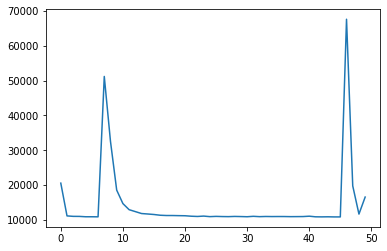

In [ ]:
print(ret['scores'])

import matplotlib.pyplot as plt
print("\n", loss)    
plt.plot(loss)
#pred = model.predict(valid_input,valid_target,1000)


Prec@50


Text(0.5, 1.0, 'Prec@50')

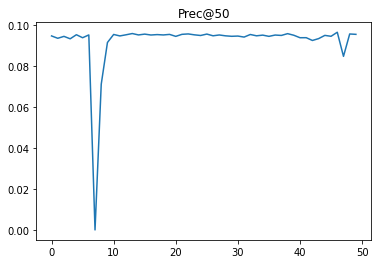

In [ ]:
print("Prec@50")
prec5 = []
for i in range(ExperimentConfig.num_epochs):
  prec5.append(list_scores[9*i+1])
#prec5.append(list_scores[-1])
plt.plot(prec5)
plt.title('Prec@50')

Recall@5


Text(0.5, 1.0, 'Recall@50')

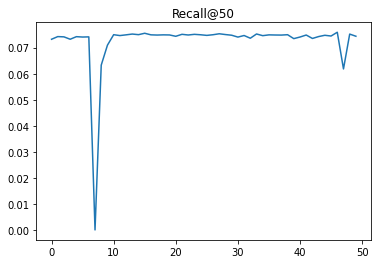

In [ ]:
print("Recall@5")
Recall = []
for i in range(ExperimentConfig.num_epochs):
  Recall.append(list_scores[9*i+2])
plt.plot(Recall)
plt.title('Recall@50')

NDCG@5


Text(0.5, 1.0, 'NDCG@50')

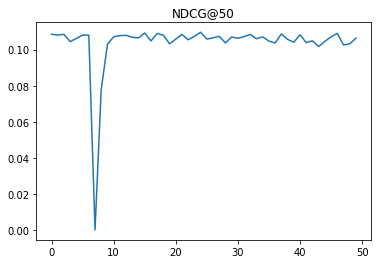

In [ ]:
print("NDCG@5")
NDCG = []
for i in range(ExperimentConfig.num_epochs):
  NDCG.append(list_scores[9*i+3])
plt.plot(NDCG)
plt.title('NDCG@50')

# TEST 2: 
*   Dimension of the latent representation K: 200 
*  *Dimension of hidden layer: 600*

600->200->600

* Annealing the Kullback-Leibler term linearly for 200,000 gradient updates. (total_anneal_steps)
*  Dropout at the input layer with probability 0.5 ('dropout': 0.5)
*  Train for 50 epochs. 
*  Batch size: 500 users 
* $\beta$: 0.0001 (regularization parameter)
* learning rate: 0.005

--- *texto en cursiva*






Metrics:

  'Prec@20': 0.13178807, 

  'Prec@50': 0.09878146, 

  'Prec@100': 0.077412255, 
  
  'Recall@20': 0.11207558, 
  
  'Recall@50': 0.20142283, 
  
  'Recall@100': 0.30110246, 
  
  'NDCG@20': 0.16318484, 
  
  'NDCG@50': 0.17826967, 
  
  'NDCG@100': 0.21093903

{'Prec@20': 0.13178807, 'Prec@50': 0.09878146, 'Prec@100': 0.077412255, 'Recall@20': 0.11207558, 'Recall@50': 0.20142283, 'Recall@100': 0.30110246, 'NDCG@20': 0.16318484, 'NDCG@50': 0.17826967, 'NDCG@100': 0.21093903}

 [tensor(18185.1348, grad_fn=<AddBackward0>), tensor(6365.4399, grad_fn=<AddBackward0>), tensor(5908.0430, grad_fn=<AddBackward0>), tensor(5776.8916, grad_fn=<AddBackward0>), tensor(5642.0376, grad_fn=<AddBackward0>), tensor(5650.7046, grad_fn=<AddBackward0>), tensor(5622.8350, grad_fn=<AddBackward0>), tensor(5610.4482, grad_fn=<AddBackward0>), tensor(5702.6504, grad_fn=<AddBackward0>), tensor(5756.5420, grad_fn=<AddBackward0>), tensor(5606.7695, grad_fn=<AddBackward0>), tensor(5526.2090, grad_fn=<AddBackward0>), tensor(5617.8838, grad_fn=<AddBackward0>), tensor(5265.3179, grad_fn=<AddBackward0>), tensor(5013.5508, grad_fn=<AddBackward0>), tensor(4975.8306, grad_fn=<AddBackward0>), tensor(4866.1045, grad_fn=<AddBackward0>), tensor(4839.7056, grad_fn=<AddBackward0>), tens

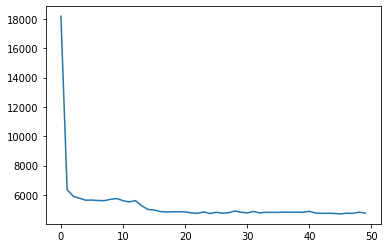

In [ ]:
print(ret['scores'])

import matplotlib.pyplot as plt
print("\n", loss)    
plt.plot(loss)
#pred = model.predict(valid_input,valid_target,1000)


Prec@20


Text(0.5, 1.0, 'Prec@50')

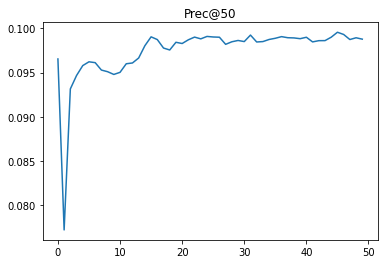

In [ ]:
print("Prec@50")
prec5 = []
for i in range(ExperimentConfig.num_epochs):
  prec5.append(list_scores[9*i+1])
#prec5.append(list_scores[-1])
plt.plot(prec5)
plt.title('Prec@50')

Recall@5


Text(0.5, 1.0, 'Recall@50')

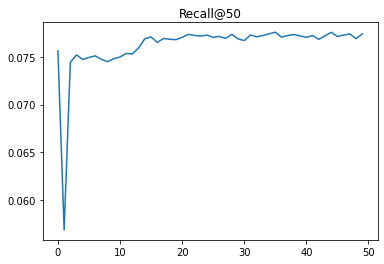

In [ ]:
print("Recall@5")
Recall = []
for i in range(ExperimentConfig.num_epochs):
  Recall.append(list_scores[9*i+2])
plt.plot(Recall)
plt.title('Recall@50')

NDCG@5


Text(0.5, 1.0, 'NDCG@50')

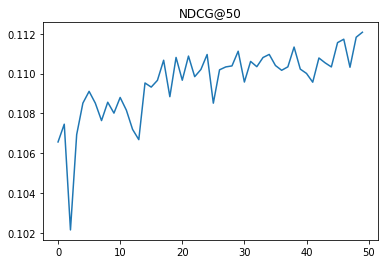

In [ ]:
print("NDCG@5")
NDCG = []
for i in range(ExperimentConfig.num_epochs):
  NDCG.append(list_scores[9*i+3])
plt.plot(NDCG)
plt.title('NDCG@50')

In [ ]:
'''pred = model.predict( dataset.valid_users, dataset.valid_input, test_batch_size=ExperimentConfig.batch_size)
target = dataset.valid_target
for idx, u in enumerate(target):
    pred_u = pred[idx]
    target_u = target[u]
    num_target_items = len(target_u)'''

# TEST 3: *********
*   Dimension of the latent representation K: 200 
*  Dimension of hidden layer: 600

600->200->600

* Annealing the Kullback-Leibler term linearly for 200,000 gradient updates. (total_anneal_steps)
*  Dropout at the input layer with probability 0.5 ('dropout': 0.5)
*  Train for 50 epochs. 
*  *Batch size: 250 users* 
* *$\beta$: 0.01 (regularization parameter)*
* learning rate: 0.005 

**Metrics:**

'Prec@20': 0.16883278, 

'Prec@50': 0.12736423, 

'Prec@100': 0.098336086, 

'Recall@20': 0.15117404, 

'Recall@50': 0.26834795, 

'Recall@100': 0.3915983, 

'NDCG@20': 0.22055064, 

'NDCG@50': 0.24321204, 

'NDCG@100': 0.28482428}


{'Prec@20': 0.16883278, 'Prec@50': 0.12736423, 'Prec@100': 0.098336086, 'Recall@20': 0.15117404, 'Recall@50': 0.26834795, 'Recall@100': 0.3915983, 'NDCG@20': 0.22055064, 'NDCG@50': 0.24321204, 'NDCG@100': 0.28482428}

 [tensor(24089.4531, grad_fn=<AddBackward0>), tensor(11191.2852, grad_fn=<AddBackward0>), tensor(10976.0410, grad_fn=<AddBackward0>), tensor(10984.2002, grad_fn=<AddBackward0>), tensor(10902.7393, grad_fn=<AddBackward0>), tensor(10915.8105, grad_fn=<AddBackward0>), tensor(10898.7412, grad_fn=<AddBackward0>), tensor(10879.6553, grad_fn=<AddBackward0>), tensor(10878.6943, grad_fn=<AddBackward0>), tensor(10580.4512, grad_fn=<AddBackward0>), tensor(9857.1504, grad_fn=<AddBackward0>), tensor(9452.9033, grad_fn=<AddBackward0>), tensor(9629.2383, grad_fn=<AddBackward0>), tensor(9326.0801, grad_fn=<AddBackward0>), tensor(9246.5059, grad_fn=<AddBackward0>), tensor(9337.3018, grad_fn=<AddBackward0>), tensor(9219.1729, grad_fn=<AddBackward0>), tensor(9215.3662, grad_fn=<AddBackward0

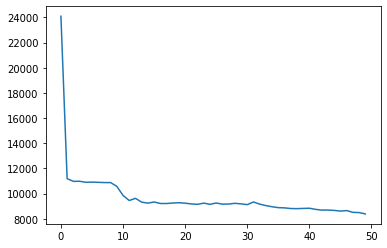

In [ ]:
print(ret['scores'])

import matplotlib.pyplot as plt
print("\n", loss)    
plt.plot(loss)
#pred = model.predict(valid_input,valid_target,1000)

Prec@50


Text(0.5, 1.0, 'Prec@50')

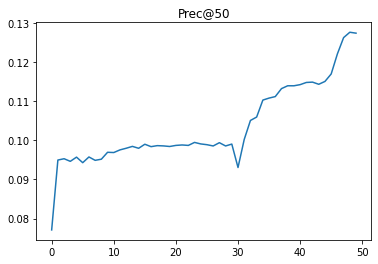

In [ ]:
print("Prec@50")
prec5 = []
for i in range(ExperimentConfig.num_epochs):
  prec5.append(list_scores[9*i+1])
#prec5.append(list_scores[-1])
plt.plot(prec5)
plt.title('Prec@50')

Recall@50


Text(0.5, 1.0, 'Recall@50')

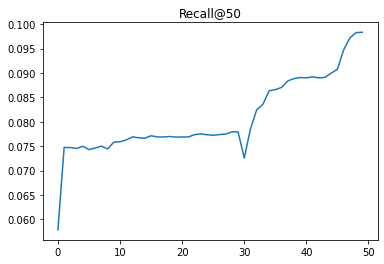

In [ ]:
print("Recall@50")
Recall = []
for i in range(ExperimentConfig.num_epochs):
  Recall.append(list_scores[9*i+2])
plt.plot(Recall)
plt.title('Recall@50')

NDCG@50


Text(0.5, 1.0, 'NDCG@50')

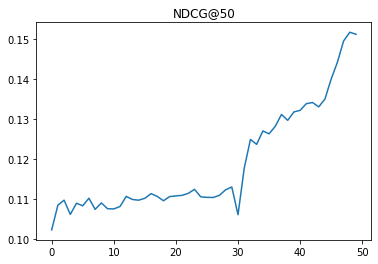

In [ ]:
print("NDCG@50")
NDCG = []
for i in range(ExperimentConfig.num_epochs):
  NDCG.append(list_scores[9*i+3])
plt.plot(NDCG)
plt.title('NDCG@50')

# TEST 4: 
*   Dimension of the latent representation K: 200 


I->200->I

* Annealing the Kullback-Leibler term linearly for 200,000 gradient updates. (total_anneal_steps)
*  Dropout at the input layer with probability 0.5 ('dropout': 0.5)
*  Train for 50 epochs. 
*  *Batch size: 250 users* 
* *$\beta$: 0.01 (regularization parameter)*
* learning rate: 0.005 

#Metrics:

'Prec@20': 0.22141558, 

'Prec@50': 0.16437085, 

'Prec@100': 0.12342715, 

'Recall@20': 0.20364279, 

'Recall@50': 0.3497488, 

'Recall@100': 0.49047297, 

'NDCG@20': 0.28869224, 

'NDCG@50': 0.31794605, 

'NDCG@100': 0.36627364}

{'Prec@20': 0.22141558, 'Prec@50': 0.16437085, 'Prec@100': 0.12342715, 'Recall@20': 0.20364279, 'Recall@50': 0.3497488, 'Recall@100': 0.49047297, 'NDCG@20': 0.28869224, 'NDCG@50': 0.31794605, 'NDCG@100': 0.36627364}

 [tensor(52368.2930, grad_fn=<AddBackward0>), tensor(21878.0488, grad_fn=<AddBackward0>), tensor(16631.3672, grad_fn=<AddBackward0>), tensor(15456.3027, grad_fn=<AddBackward0>), tensor(14359.1104, grad_fn=<AddBackward0>), tensor(13474.7529, grad_fn=<AddBackward0>), tensor(12681.5508, grad_fn=<AddBackward0>), tensor(11978.0996, grad_fn=<AddBackward0>), tensor(11616.4512, grad_fn=<AddBackward0>), tensor(11201.5898, grad_fn=<AddBackward0>), tensor(10783.1104, grad_fn=<AddBackward0>), tensor(10555.5186, grad_fn=<AddBackward0>), tensor(10487.5352, grad_fn=<AddBackward0>), tensor(10236.2949, grad_fn=<AddBackward0>), tensor(10097.7910, grad_fn=<AddBackward0>), tensor(10059.7295, grad_fn=<AddBackward0>), tensor(9862.3447, grad_fn=<AddBackward0>), tensor(9750.9727, grad_fn=<AddBack

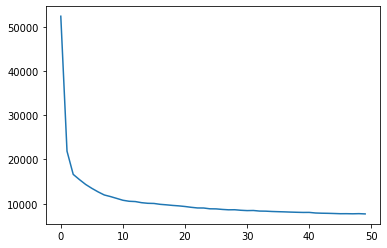

In [ ]:
print(ret['scores'])

import matplotlib.pyplot as plt
print("\n", loss)    
plt.plot(loss)
#pred = model.predict(valid_input,valid_target,1000)

Prec@50


Text(0.5, 1.0, 'Prec@50')

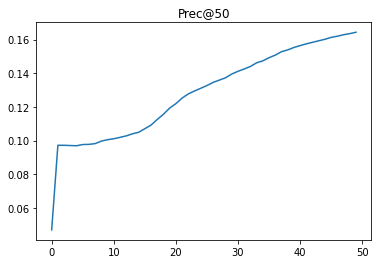

In [ ]:
print("Prec@50")
prec5 = []
for i in range(ExperimentConfig.num_epochs):
  prec5.append(list_scores[9*i+1])
#prec5.append(list_scores[-1])
plt.plot(prec5)
plt.title('Prec@50')

Recall@50


Text(0.5, 1.0, 'Recall@50')

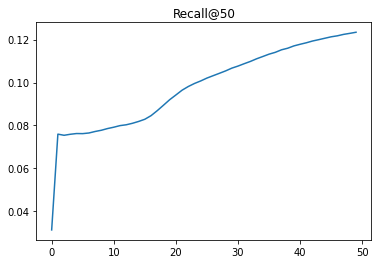

In [ ]:
print("Recall@50")
Recall = []
for i in range(ExperimentConfig.num_epochs):
  Recall.append(list_scores[9*i+2])
plt.plot(Recall)
plt.title('Recall@50')

NDCG@50


Text(0.5, 1.0, 'NDCG@50')

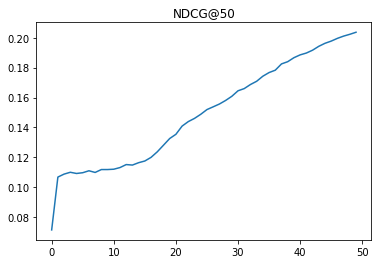

In [ ]:
print("NDCG@50")
NDCG = []
for i in range(ExperimentConfig.num_epochs):
  NDCG.append(list_scores[9*i+3])
plt.plot(NDCG)
plt.title('NDCG@50')

# TEST 5: 
*   Dimension of the latent representation K: 100 


I->100->I

* Annealing the Kullback-Leibler term linearly for 200,000 gradient updates. (total_anneal_steps)
*  Dropout at the input layer with probability 0.5 ('dropout': 0.5)
*  Train for 50 epochs. 
*  *Batch size: 250 users* 
* *$\beta$: 0.01 (regularization parameter)*
* learning rate: 0.005 

#Metrics:

'Prec@20': 0.20047185, 

'Prec@50': 0.14929138, 

'Prec@100': 0.113399, 

'Recall@20': 0.1763435, 

'Recall@50': 0.30717802, 

'Recall@100': 0.44264773, 

'NDCG@20': 0.25988668, 

'NDCG@50': 0.28355676, 

'NDCG@100': 0.32940912

{'Prec@20': 0.20047185, 'Prec@50': 0.14929138, 'Prec@100': 0.113399, 'Recall@20': 0.1763435, 'Recall@50': 0.30717802, 'Recall@100': 0.44264773, 'NDCG@20': 0.25988668, 'NDCG@50': 0.28355676, 'NDCG@100': 0.32940912}

 [tensor(57159.1523, grad_fn=<AddBackward0>), tensor(29426.5488, grad_fn=<AddBackward0>), tensor(18563.6387, grad_fn=<AddBackward0>), tensor(16682.5625, grad_fn=<AddBackward0>), tensor(15585.8564, grad_fn=<AddBackward0>), tensor(14843.7920, grad_fn=<AddBackward0>), tensor(14179.5312, grad_fn=<AddBackward0>), tensor(13548.8975, grad_fn=<AddBackward0>), tensor(13084.3262, grad_fn=<AddBackward0>), tensor(12609.0273, grad_fn=<AddBackward0>), tensor(11998.8389, grad_fn=<AddBackward0>), tensor(11643.2422, grad_fn=<AddBackward0>), tensor(11544.5615, grad_fn=<AddBackward0>), tensor(11218.9043, grad_fn=<AddBackward0>), tensor(10991.0420, grad_fn=<AddBackward0>), tensor(10856.0176, grad_fn=<AddBackward0>), tensor(10600.4473, grad_fn=<AddBackward0>), tensor(10482.3916, grad_fn=<AddBack

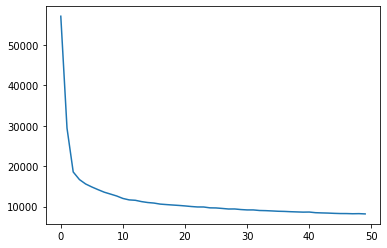

In [ ]:
print(ret['scores'])

import matplotlib.pyplot as plt
print("\n", loss)    
plt.plot(loss)

Prec@50


Text(0.5, 1.0, 'Prec@50')

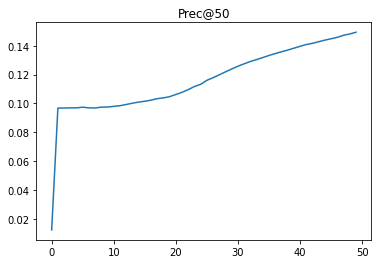

In [ ]:
print("Prec@50")
prec5 = []
for i in range(ExperimentConfig.num_epochs):
  prec5.append(list_scores[9*i+1])
#prec5.append(list_scores[-1])
plt.plot(prec5)
plt.title('Prec@50')

Recall@50


Text(0.5, 1.0, 'Recall@50')

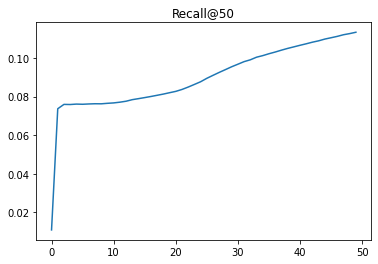

In [ ]:
print("Recall@50")
Recall = []
for i in range(ExperimentConfig.num_epochs):
  Recall.append(list_scores[9*i+2])
plt.plot(Recall)
plt.title('Recall@50')

NDCG@50


Text(0.5, 1.0, 'NDCG@50')

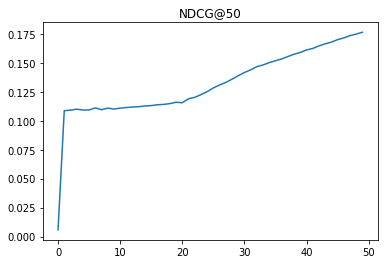

In [ ]:
print("NDCG@50")
NDCG = []
for i in range(ExperimentConfig.num_epochs):
  NDCG.append(list_scores[9*i+3])
plt.plot(NDCG)
plt.title('NDCG@50')

# TEST 6: ****** 
*   Dimension of the latent representation K: 300 


I->300->I

* Annealing the Kullback-Leibler term linearly for 200,000 gradient updates. (total_anneal_steps)
*  Dropout at the input layer with probability 0.5 ('dropout': 0.5)
*  Train for 50 epochs. 
*  *Batch size: 250 users* 
* *$\beta$: 0.01 (regularization parameter)*
* learning rate: 0.005 

#Metrics:
'Prec@20': 0.2292798, 

'Prec@50': 0.1697914, 

'Prec@100': 0.12702152, 

'Recall@20': 0.2153419, 

'Recall@50': 0.36685577, 

'Recall@100': 0.5099808, 

'NDCG@20': 0.30023974, 

'NDCG@50': 0.33157772, 

'NDCG@100': 0.38099474

{'Prec@20': 0.2292798, 'Prec@50': 0.1697914, 'Prec@100': 0.12702152, 'Recall@20': 0.2153419, 'Recall@50': 0.36685577, 'Recall@100': 0.5099808, 'NDCG@20': 0.30023974, 'NDCG@50': 0.33157772, 'NDCG@100': 0.38099474}

 [tensor(48345.9219, grad_fn=<AddBackward0>), tensor(19177.2480, grad_fn=<AddBackward0>), tensor(15967.4561, grad_fn=<AddBackward0>), tensor(14755.6250, grad_fn=<AddBackward0>), tensor(13563.2725, grad_fn=<AddBackward0>), tensor(12554.9541, grad_fn=<AddBackward0>), tensor(11814.3135, grad_fn=<AddBackward0>), tensor(11243.5918, grad_fn=<AddBackward0>), tensor(10932.6016, grad_fn=<AddBackward0>), tensor(10682.8789, grad_fn=<AddBackward0>), tensor(10324.6055, grad_fn=<AddBackward0>), tensor(10078.4844, grad_fn=<AddBackward0>), tensor(10065.0371, grad_fn=<AddBackward0>), tensor(9752.0625, grad_fn=<AddBackward0>), tensor(9598.7119, grad_fn=<AddBackward0>), tensor(9530.8506, grad_fn=<AddBackward0>), tensor(9324.1367, grad_fn=<AddBackward0>), tensor(9179.3594, grad_fn=<AddBackward0>

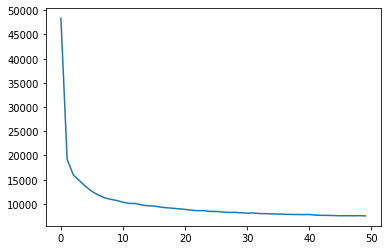

In [ ]:
print(ret['scores'])

import matplotlib.pyplot as plt
print("\n", loss)    
plt.plot(loss)

Prec@50


Text(0.5, 1.0, 'Prec@50')

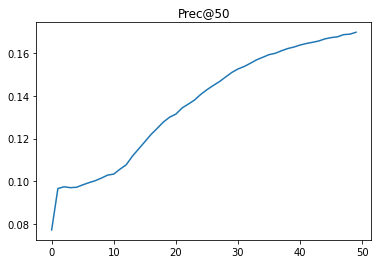

In [ ]:
print("Prec@50")
prec5 = []
for i in range(ExperimentConfig.num_epochs):
  prec5.append(list_scores[9*i+1])
#prec5.append(list_scores[-1])
plt.plot(prec5)
plt.title('Prec@50')

Recall@50


Text(0.5, 1.0, 'Recall@50')

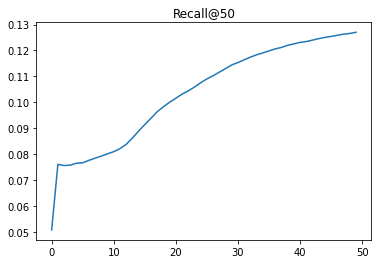

In [ ]:
print("Recall@50")
Recall = []
for i in range(ExperimentConfig.num_epochs):
  Recall.append(list_scores[9*i+2])
plt.plot(Recall)
plt.title('Recall@50')

NDCG@50


Text(0.5, 1.0, 'NDCG@50')

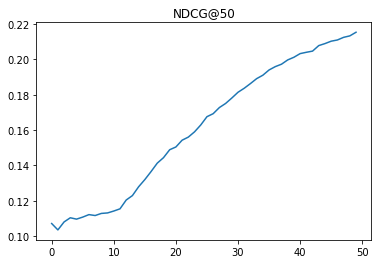

In [ ]:
print("NDCG@50")
NDCG = []
for i in range(ExperimentConfig.num_epochs):
  NDCG.append(list_scores[9*i+3])
plt.plot(NDCG)
plt.title('NDCG@50')

# TEST 7: 
*   Dimension of the latent representation K: 300 


I->300->I

* Annealing the Kullback-Leibler term linearly for 200,000 gradient updates. (total_anneal_steps)
*  Dropout at the input layer with probability 0.5 ('dropout': 0.5)
*  Train for 50 epochs. 
*  *Batch size: 250 users* 
* *$\beta$: 0.2 (regularization parameter)*
* learning rate: 0.005 

#Metrics:

'Prec@20': 0.22141558, 

'Prec@50': 0.16437085, 

'Prec@100': 0.12342715, 

'Recall@20': 0.20364279, 

'Recall@50': 0.3497488, 

'Recall@100': 0.49047297, 

'NDCG@20': 0.28869224, 

'NDCG@50': 0.31794605, 

'NDCG@100': 0.36627364

{'Prec@20': 0.22141558, 'Prec@50': 0.16437085, 'Prec@100': 0.12342715, 'Recall@20': 0.20364279, 'Recall@50': 0.3497488, 'Recall@100': 0.49047297, 'NDCG@20': 0.28869224, 'NDCG@50': 0.31794605, 'NDCG@100': 0.36627364}

 [tensor(52368.2930, grad_fn=<AddBackward0>), tensor(21878.0488, grad_fn=<AddBackward0>), tensor(16631.3672, grad_fn=<AddBackward0>), tensor(15456.3027, grad_fn=<AddBackward0>), tensor(14359.1104, grad_fn=<AddBackward0>), tensor(13474.7529, grad_fn=<AddBackward0>), tensor(12681.5508, grad_fn=<AddBackward0>), tensor(11978.0996, grad_fn=<AddBackward0>), tensor(11616.4512, grad_fn=<AddBackward0>), tensor(11201.5898, grad_fn=<AddBackward0>), tensor(10783.1104, grad_fn=<AddBackward0>), tensor(10555.5186, grad_fn=<AddBackward0>), tensor(10487.5352, grad_fn=<AddBackward0>), tensor(10236.2949, grad_fn=<AddBackward0>), tensor(10097.7910, grad_fn=<AddBackward0>), tensor(10059.7295, grad_fn=<AddBackward0>), tensor(9862.3447, grad_fn=<AddBackward0>), tensor(9750.9727, grad_fn=<AddBack

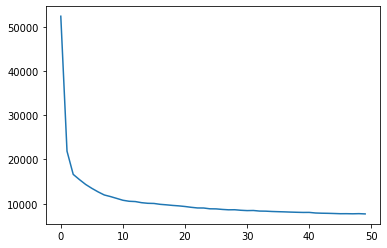

In [ ]:
print(ret['scores'])

import matplotlib.pyplot as plt
print("\n", loss)    
plt.plot(loss)

Prec@50


Text(0.5, 1.0, 'Prec@50')

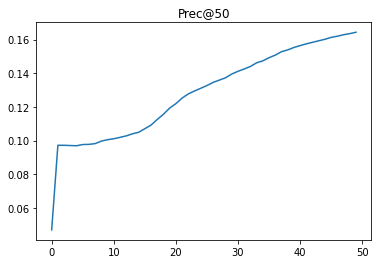

In [ ]:
print("Prec@50")
prec5 = []
for i in range(ExperimentConfig.num_epochs):
  prec5.append(list_scores[9*i+1])
#prec5.append(list_scores[-1])
plt.plot(prec5)
plt.title('Prec@50')

Recall@50


Text(0.5, 1.0, 'Recall@50')

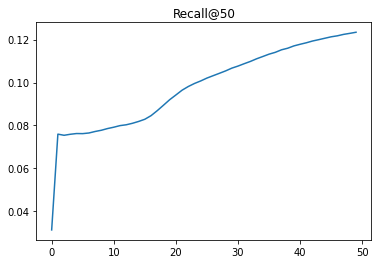

In [ ]:
print("Recall@50")
Recall = []
for i in range(ExperimentConfig.num_epochs):
  Recall.append(list_scores[9*i+2])
plt.plot(Recall)
plt.title('Recall@50')

NDCG@50


Text(0.5, 1.0, 'NDCG@50')

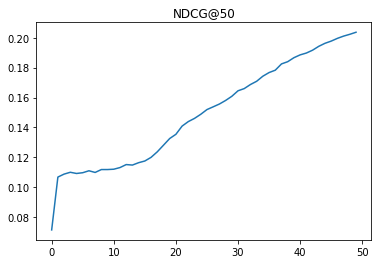

In [ ]:
print("NDCG@50")
NDCG = []
for i in range(ExperimentConfig.num_epochs):
  NDCG.append(list_scores[9*i+3])
plt.plot(NDCG)
plt.title('NDCG@50')